<a href="https://colab.research.google.com/github/Saharmgh/ML-bootcamp/blob/main/PCA_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Background**
Prinicipal Component Analysis (PCA): is an unsupervised learning method that is often used to reduce the dimentionality of the dataset by transforming a large set into a lower dimensional set that still contains most of the information of the large set.

Here with diemsion we mean features. So we want to find the tranformatopn in such a way that the transfomed features are orthogonal, and linearly independant. We reduce the dimension by choosing only dimensions (features) with highest importance. Those newly found dimensions should minimize the projection error meaning that the representation of the data in reduced dimension space should retain as much information as possible from the original data. The objective function is to maximize the spread of the data (i.e.variance) along prinicipal components.   



***Variance***:
$Var(X)$ is a measure of the spread or dispersion of a dataset. The formula is given by:

$ Var(X) = \frac{1}{N} \sum_{i=1}^{N} (X_i - \bar{X})^2 $

Here, $N$ represents the number of data points, $X_i$ denotes individual data points, and $bar{X}$ is the mean.


***Covariance:*** $Cov(X, Y)$ is a measure of how much two variables, $X$ and $Y$, change together. The covariance formula is expressed as:

$Cov(X, Y) = \frac{1}{N} \sum_{i=1}^{N} (X_i - \bar{X})(Y_i - \bar{Y})^T $

Here, $N$ represents the number of data points, $X_i$ and $Y_i$ denote individual data points respectively, and $\bar{X}$ and $\bar{Y}$ are the means of the respective datasets. The formula calculates the average of the product of the deviations of each data point from their respective means, providing insight into the directional relationship between $X$ and $Y$.


In linear algebra, given a square matrix $A$, an eigenvector $v$ and its corresponding eigenvalue $\lambda$ satisfy the equation:

$ Av = \lambda v $

Eigenvectors represent directions in the matrix space, and eigenvalues quantify the scaling factor of these directions. In the context of PCA,  The eigenvectors represent the directions of maximum variance, and the eigenvalues indicate the magnitude of variance along these directions.


# **Data Example**

In [3]:
#import the required libraries
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
import pandas as pd
import time
import os
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [ ]:
#First test dataset
from sklearn.datasets import make_blobs
n_features = 10
X, y = make_blobs(centers=3, n_samples=1000, n_features=n_features)

In [4]:
#Second test dataset
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams.update({'font.size': 18})

obs= np.loadtxt('ovariancancer_obs.csv',delimiter=',')
f = open('ovariancancer_grp.csv', "r")
grp = f.read().split("\n")
print(f' Number of patients: {obs.shape[0]} \n Certain features: {obs.shape[1]}')

 Number of patients: 216 
 Certain features: 4000


To convey the inherent complexity of visualizing high-dimensional data, the following pairwise plot provides a glimpse into the relationships between different features. Recognizing patterns in such complex data structures can be challenging, highlighting the need for dimensionality reduction techniques.


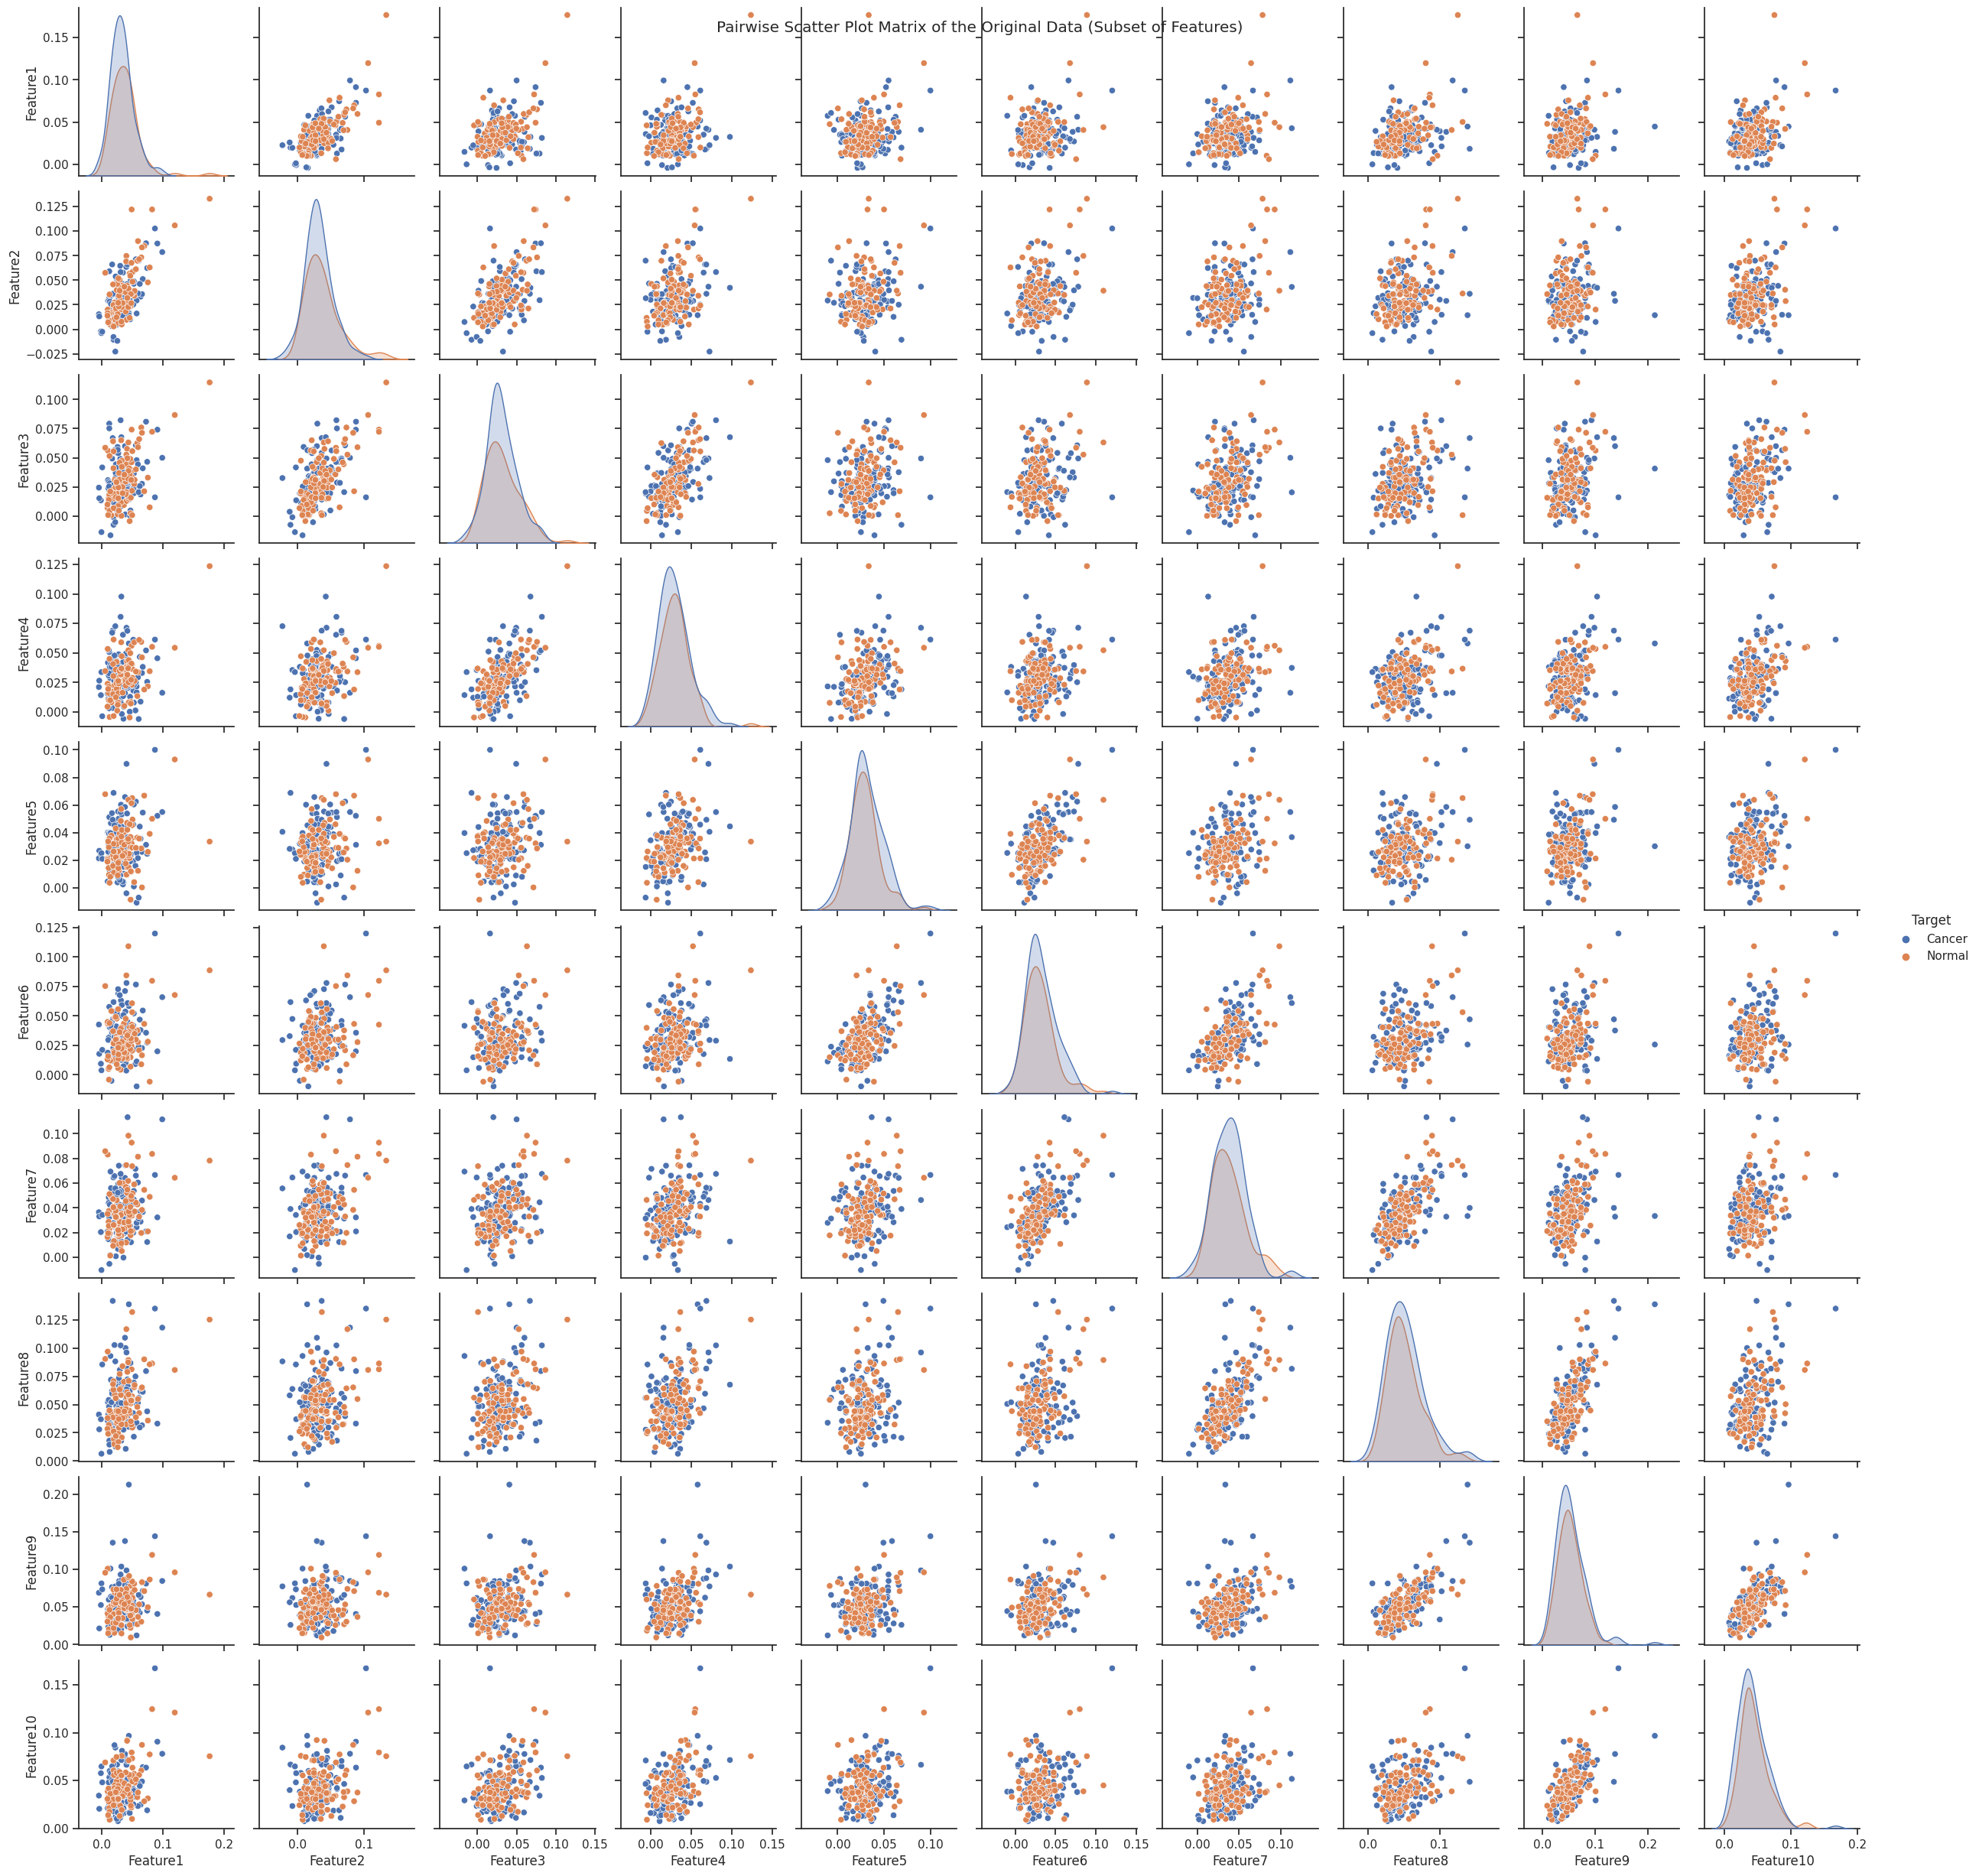

In [24]:
subset_features = 10
df_subset = pd.DataFrame(obs[:, :subset_features], columns=[f'Feature{i}' for i in range(1, subset_features+1)])
df_subset['Target'] = grp[:-1]

# Pairwise plot for the subset of features
sns.set(style="ticks")
sns.pairplot(df_subset, hue="Target", markers="o")
plt.suptitle("Pairwise Scatter Plot Matrix of the Original Data (Subset of Features)")
plt.show()

# **PCA with Eigen Decomposition (EVD)**
Here the aim is to capture the directions in the data space along which the variance is maximized.
**Steps:**

1. **Centering the Data:**
For each variable, subtract the mean ($\mu_j$) from all its values:
$ X_{\text{centered}} = X - \bar{X} $

2. **Calculate the Covariance Matrix:**
The covariance matrix ($\text{Cov}(X, X)$ is calculated as the outer product of the centered data matrix:
$ \text{Cov}(X, X) = X_{\text{centered}} \cdot X_{\text{centered}}^T $

3. **Compute Eigenvalues and Eigenvectors:**
Let $A = \text{Cov}(X, X)$. Solve the characteristic equation:
$\text{det}(A - \lambda I) = 0 $. This yields the eigenvalues ($\lambda_i$) and corresponding eigenvectors ($v_i$):
$ A v_i = \lambda_i v_i $.

4. **Sort Eigenvectors:**
Sort the eigenvectors according to their corresponding eigenvalues in decreasing order. Let $V$ be the matrix containing the eigenvectors, and $\Lambda$ be a diagonal matrix containing the eigenvalues.

5. **Choose $k$ Eigenvectors:**
Select the first $k$ eigenvectors (columns of $V$) corresponding to the $k$ largest eigenvalues.
$V_k = \begin{bmatrix} | & | & \cdots & | \\ v_1 & v_2 & \cdots & v_k \\ | & | & \cdots & | \end{bmatrix}$

6. **Transform Data:**
Project the original $n$-dimensional data points into the new $k$-dimensional space using the selected eigenvectors:
$ \text{Projected Data} = X_{\text{centered}} \cdot V_k $

This is essentially a dot product between the centered data matrix and the selected eigenvectors.

In [16]:
class Newpca:
  def __init__(self, percentage):
    self.percentage= percentage
    self.n_components= None
    self.components= None
    self.mean = None
    self.scale = None
    self.cum_explained_variance = None
    self.explained_variance_ratio = None
    self.n_flops= None
    self.egv_time= None
  # Keep in mind this is an unsupervised method so we do not need labels
  def fit(self, X):
    start_time = time.time()
    # mean centerting
    X= X.copy()
    self.mean = np.mean(X, axis=0)
    self.scale= np.std(X, axis = 0)
    X_std= (X - self.mean) / self.scale

    # Calculate the covariance matrix
    cov = np.cov(X_std.T)
    # Calculate the eigenvectors and eigenvalues
    evalues, evectors = np.linalg.eig(cov)
    evectors= evectors.T


    # sort eigenvectors
    idxs= np.argsort(evalues)[::-1]
    evalues_sorted= evalues[idxs]
    evectors_sorted = evectors[idxs]
    # The alg selects enough components to explain enough of the variance

    total_var= np.sum(evalues)
    explained_variance_treshold= total_var *self.percentage
    cumulative_variance = 0
    self.n_components= 0
    for variance in evalues_sorted:
      cumulative_variance += variance
      self.n_components += 1
      if  cumulative_variance >= explained_variance_treshold:
            break

    self.components = evectors_sorted[:self.n_components,:]
    self.explained_variance_ratio = np.real([i/np.sum(evalues) for i in evalues_sorted[:self.n_components]])
    self.cum_explained_variance =  np.real(np.cumsum(self.explained_variance_ratio))
    self.n_flops= np.sum([np.prod(matrix.shape) for matrix in [evectors]])
    self.egv_time = time.time() - start_time

    return self

    # user can set the desired number of components
  def transform(self, X):
    X= X.copy()
    X_std= (X- self.mean) / self.scale
    res=  np.dot(X_std, self.components.T)

    return res

In [17]:
#argument in percentage
pca= Newpca(0.95)
pca.fit(obs)
X_projected= pca.transform(obs)
print('Transformed data shape:', X_projected.shape)

Transformed data shape: (216, 167)


You might question what is meant by the term '0.95%'? This percentage reflects a more confident approach for truncating the eigenvectors. The optimal number of components can be determined through Cumulative Explained Variance, which indicates how much information (variance) can be attributed to each of the principal components. So basically when you set a threshold, such as 95%, for cumulative explained variance, you are essentially asking the algorithm to choose the number of components that collectively explain at least 95% of the total variance in the dataset.

Let's plot the dataset in lower dimension:


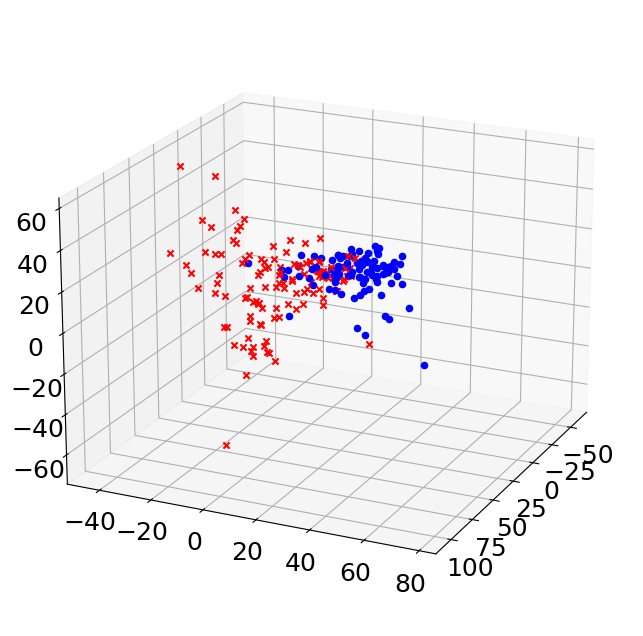

In [8]:
fig2= plt.figure()
ax= fig2.add_subplot(111, projection ='3d')
for j in range(obs.shape[0]):
  x= X_projected[j, 0 ]
  y= X_projected[j, 1]
  z= X_projected[j, 2]

  if grp[j] == 'Cancer':
    ax.scatter(x,y,z, marker= 'x', color= 'r', s= 20)
  else:
    ax.scatter(x,y,z, marker= 'o', color= 'b', s= 20)

ax.view_init(20, 25)
plt.show()

As you can see in this figure, three components obtained from PCA, are sufficient to differentiate between the two classes: patients with cancer and patients without cancer.

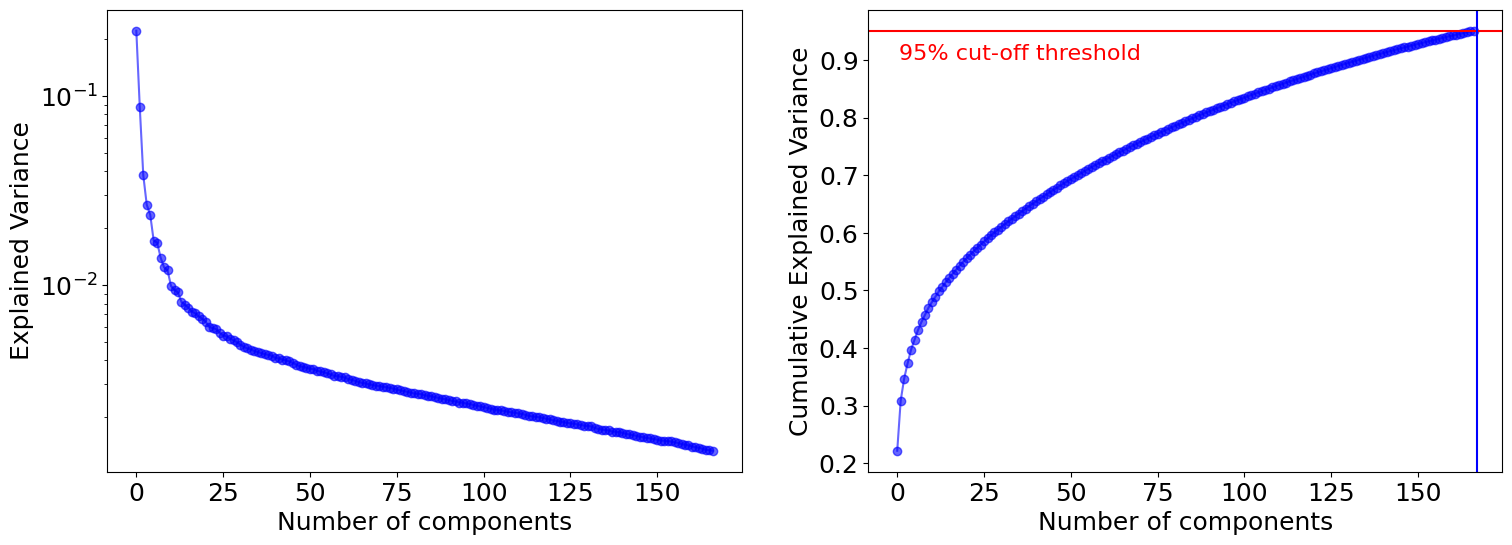

In [9]:
fig1= plt.figure(figsize= (18,6))
ax1 = fig1.add_subplot(121)
ax1.semilogy(pca.explained_variance_ratio, '-o', color= 'b', alpha= 0.6)
ax1.set_xlabel('Number of components')
ax1.set_ylabel('Explained Variance')
ax2 = fig1.add_subplot(122)
ax2.plot(pca.cum_explained_variance.round(4), '-o', color= 'b', alpha= 0.6)
# ax2.set_title(f'{pca.n_components} components, captures {pca.cum_explained_variance[pca.n_components-1].round(4)*100}% of total variation')
ax2.set_xlabel('Number of components')
ax2.set_ylabel('Cumulative Explained Variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.axvline(x= pca.n_components, color='b', linestyle='-')
plt.text(0.5, 0.9, '95% cut-off threshold', color = 'red', fontsize=16)


plt.show()






# **PCA with Singular Value Decomposition (SVD)**

The Singular Value Decomposition (SVD) of a $m*n$ matrix $X$ is a factorization into three matrices $U$, $\Sigma$, and $V^T$ such that:

$ X = U \cdot \Sigma \cdot V^T $

Where:
- $U$ is an orthogonal matrix representing the left singular vectors with the size of $m*m$.
- $\Sigma$ is a diagonal matrix containing the singular values with the size of $n*m$.
- $V^T$ is the transpose of an orthogonal matrix representing the right singular vector with the size of $n*n$.


In [10]:
class PCA_SVD:
    def __init__(self, percentage ):
        self.n_components = None
        self.components = None
        self.mean = None
        self.cum_sum_singular = None
        self.S= None
        self.n_flops = None
        self.svd_time = None
        self.percentage = percentage


    def fit(self, X):
        # mean centerting
        start_time= time.time()
        X= X.copy()
        self.mean = np.mean(X, axis=0)
        self.scale= np.std(X, axis = 0)
        X_std= (X - self.mean) / self.scale



        # Calculate economic SVD
        U, Sigma, Vt = np.linalg.svd(X_std, full_matrices=False)
        self.S= Sigma
        explained_variance = (self.S **2) / (X.shape[0]-1)
        total_var = explained_variance.sum()
        explained_variance_ratio = explained_variance / total_var
        self.cum_sum_singular = np.cumsum(explained_variance_ratio) / np.sum(explained_variance_ratio)

        explained_variance_treshold= total_var *self.percentage
        cumulative_variance = 0
        self.n_components= 0
        for variance in explained_variance:
          cumulative_variance += variance
          self.n_components += 1
          if  cumulative_variance >= explained_variance_treshold:
                break

        self.components = Vt.T[:, :self.n_components]
        self.n_flops= np.sum([np.prod(matrix.shape) for matrix in [U, Sigma, Vt]])
        self.svd_time = time.time() - start_time



        # self.cum_sum_singular = np.cumsum(Sigma)/ np.sum(Sigma)

    def transform(self, X):
        X= X.copy()
        X_std= (X- self.mean) / self.scale
        res= np.dot(X_std, self.components)

        return res

In [11]:
pca_svd = PCA_SVD(0.95)
pca_svd.fit(obs)
X_projected_svd = pca_svd.transform(obs)
print('Transformed data shape:', X_projected_svd.shape)

Transformed data shape: (216, 167)


We want to plot the singular values. Fraction of the energy captured by the first $r$.

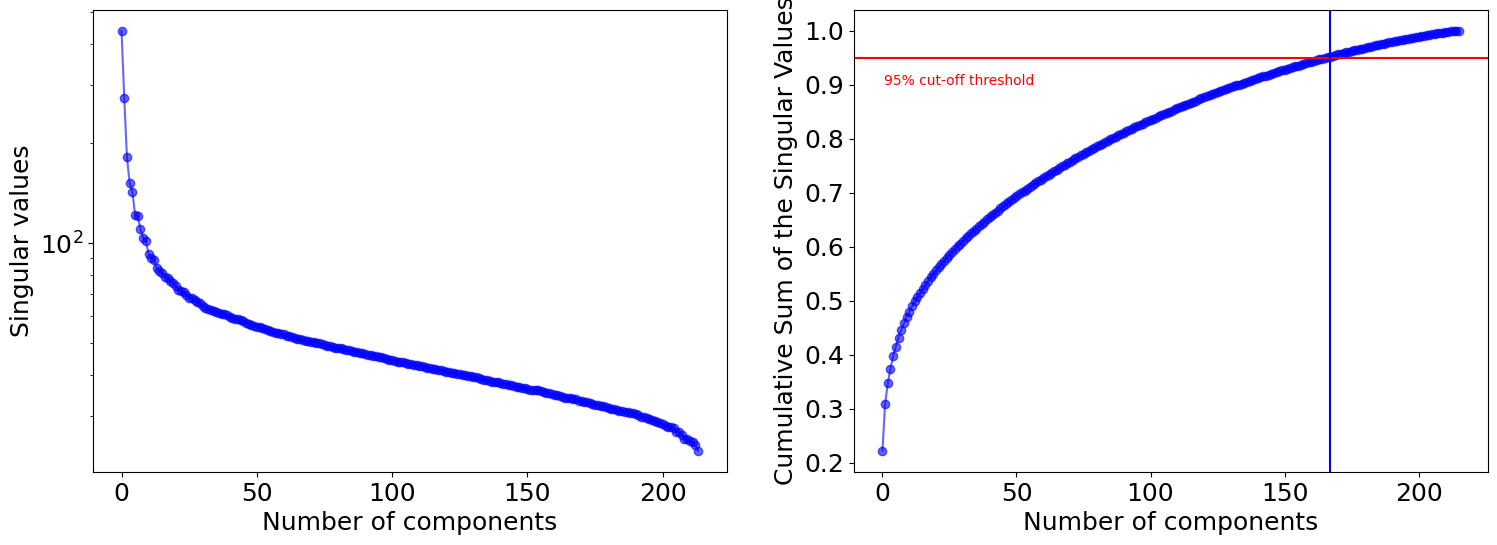

In [12]:
fig1= plt.figure(figsize= (18,6))
ax1 = fig1.add_subplot(121)
ax1.semilogy(pca_svd.S[:-2], '-o', color= 'b', alpha= 0.6)
ax1.set_xlabel('Number of components')
ax1.set_ylabel('Singular values')
ax2 = fig1.add_subplot(122)
ax2.plot(pca_svd.cum_sum_singular.round(4), '-o', color= 'b', alpha= 0.6)
# ax2.set_title('3 components, captures {}% of total variation'.format(pca_svd.cum_sum_singular[2].round(4)*100))
ax2.set_xlabel('Number of components')
ax2.set_ylabel('Cumulative Sum of the Singular Values')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.axvline(x=pca_svd.n_components, color='b', linestyle='-')
plt.text(0.5, 0.9, '95% cut-off threshold', color = 'red', fontsize=10)

plt.show()

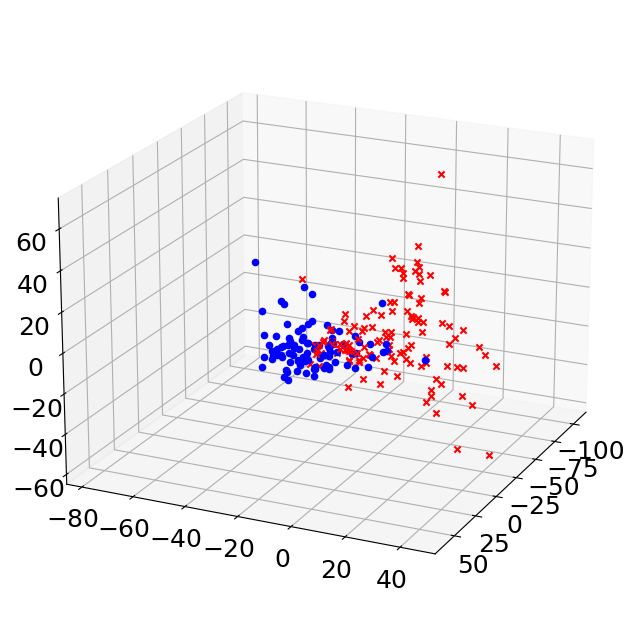

In [ ]:
fig2= plt.figure()
ax= fig2.add_subplot(111, projection ='3d')
for j in range(obs.shape[0]):
  x= X_projected_svd[j, 0 ]
  y= X_projected_svd[j, 1]
  z= X_projected_svd[j, 2]

  if grp[j] == 'Cancer':
    ax.scatter(x,y,z, marker= 'x', color= 'r', s= 20)
  else:
    ax.scatter(x,y,z, marker= 'o', color= 'b', s= 20)

ax.view_init(20, 25)
plt.show()

# **PCA with Scikit-Learn**

In [13]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(obs)

from sklearn.decomposition import PCA
start_time= time.time()
pca = PCA(0.95).fit(X_std)
cum_explained_variance = np.cumsum(pca.explained_variance_ratio_)
X_pca = pca.transform(X_std) # Apply dimensionality reduction to X.
end_time= time.time()
run_time= end_time- start_time
print('Transformed data shape:', X_pca.shape)

Transformed data shape: (216, 167)


Now, let's compare the results:



In [18]:
from prettytable import PrettyTable
table= PrettyTable()
table.field_names = ["Algorithm", " # PC", "Running Time (s)", "Number of Flops"]
table.add_row(["SVD", f"{pca_svd.n_components}", f"{pca_svd.svd_time:.4f}", f"{pca_svd.n_flops}"])
table.add_row(["EGV", f"{pca.n_components}", f"{pca.egv_time:.4f}", f"{pca.n_flops}"])
table.add_row(["Scikitlearn PCA", "167", f"{run_time:.4f}", ""])
print(table)

+-----------------+-------+------------------+-----------------+
|    Algorithm    |  # PC | Running Time (s) | Number of Flops |
+-----------------+-------+------------------+-----------------+
|       SVD       |  167  |      0.4955      |      910872     |
|       EGV       |  167  |     69.3535      |     16000000    |
| Scikitlearn PCA |  167  |      0.3262      |                 |
+-----------------+-------+------------------+-----------------+


# **PCA-SVD from Scratch with Minimal Reconstruction Error**


**Algorithm for Custom SVD with Reconstruction Error Calculation**

The SVD process involves the following steps:

1. **Mean Centering and Standardization:**
   - Compute the mean $\mu$ and standard deviation $\sigma$ of each feature in $X$.
   - Standardize $X$ by subtracting the mean and dividing by the standard deviation.

   $ X_{\text{std}} = \frac{(X - \mu)}{\sigma} $

2. **Compute \(U\) Matrix:**
   - Calculate the covariance matrix $X.X^T$ and find its eigenvectors and eigenvalues.
   - Sort eigenvectors and eigenvalues in descending order.
   - Form the $U$ matrix from the sorted eigenvectors.
   $ U = \text{eigenvectors of } X.X^T $

3. **Compute \(V\) Matrix:**

   - Form the $V^T$ matrix from the sorted eigenvectors.
   $ V^T = \text{eigenvectors of } X^T.X $

4. **Compute ($\Sigma$) Matrix:**
   - Determine the eigenvalues of either $X.X^T$ or $X^T.X$ (whichever has a smaller size for efficient calculation).
   - Sort and calculate the square root of the eigenvalues to obtain the singular values.
   $ \Sigma = \sqrt{\text{eigenvalues}} $

5. **Dimensionality Reduction:**
   - Calculate the explained variance and cumulative explained variance.
   - Define a threshold for the total explained variance based on a user-defined percentage.
   - Determine the number of components $k$ that satisfy the threshold.
   $ \text{Explained Variance Ratio} = \frac{\text{Explained Variance}}{\text{Total Variance}} $


6. **Calculate Reconstruction Error:**
   - Transform the standardized input matrix using the reduced $V^T$ matrix.
   - Compute the RMSE between the original standardized matrix and the transformed matrix.
   $ \text{RMSE} = \sqrt{\frac{\sum{(X_{\text{std}} - \text{Transformed Matrix})^2}}{m \times n}} $


   where \(m\) is the number of samples and \(n\) is the number of features.

In [7]:
class Mysvd:
    def __init__(self, percentage):
        self.n_components = None
        self.components = None
        self.mean = None
        self.cum_sum_singular = None
        self.S= None
        self.n_flops = None
        self.svd_time = None
        self.RMSE= None
        self.percentage = percentage


    def fit(self, X):
        # mean centerting
        start_time= time.time()
        X= X.copy()
        self.mean = np.mean(X, axis=0)
        self.scale= np.std(X, axis = 0)
        X_std= (X - self.mean) / self.scale



        # Calculating the eigenvalues for A.A^T to find U matrix
        _u = np.dot(X_std, X_std.T)
        u_evalue , u_evec = np.linalg.eig(_u)

        # Sorting the eigenvalues and eigenvectors
        indx_u = np.argsort(u_evalue)[::-1]
        sorted_evalue_u = u_evalue[indx_u]

        sorted_evec_u = u_evec[:,indx_u]
        U = sorted_evec_u

        # Calculating the eigenvalues for A^T.A to find V matrix
        _v = np.dot(X_std.T, X_std)
        v_evalue , v_evec = np.linalg.eig(_v)


        indx_v = np.argsort(v_evalue)[::-1]
        sorted_evalue_v = v_evalue[indx_v]

        sorted_evec_v = v_evec[:,indx_v]
        Vt = sorted_evec_v.T


        # Calculating the Sigma matrix
        if np.size(np.dot(X_std, X_std.T)) > np.size(np.dot(X_std.T, X_std)):
          X_new = np.dot(X_std.T, X_std)
        else:
          X_new = np.dot(X_std, X_std.T)

        s_evalue, s_evec = np.linalg.eig(X_new)
        indx_s= np.argsort(s_evalue)[::-1]
        sorted_evalue_s = s_evalue[indx_s]
        Sigma= np.sqrt(sorted_evalue_s)
        self.S= Sigma


        explained_variance = (self.S **2) / (X.shape[0]-1)
        total_var = explained_variance.sum()
        explained_variance_ratio = explained_variance / total_var
        self.cum_sum_singular = np.cumsum(explained_variance_ratio) / np.sum(explained_variance_ratio)

        # define the treshold
        explained_variance_treshold= total_var *self.percentage
        cumulative_variance = 0
        self.n_components= 0
        for variance in explained_variance:
          cumulative_variance += variance
          self.n_components += 1
          if  cumulative_variance >= explained_variance_treshold:
                break

        self.components = Vt.T[:, :self.n_components]
        self.n_flops= np.sum([np.prod(matrix.shape) for matrix in [U, Sigma, Vt]])
        self.svd_time = time.time() - start_time


    def transform(self, X):
        X= X.copy()
        X_std= (X- self.mean) / self.scale
        res= np.dot(X_std, self.components)
        #compute the reconstruction error
        MSE = np.square(np.subtract(X_std[:,:self.n_components],res)).mean()
        self.RMSE = sqrt(MSE)/ sqrt(X_std.shape[1])


        return res


In [42]:
pca_mysvd = Mysvd(0.95)

X_mysvd_fit= pca_mysvd .fit(obs)
X_mysvd_projected= pca_mysvd.transform(obs)
print(X_mysvd_projected.shape)

(216,) (4000, 4000) (216, 216)
(216, 167)


<ipython-input-40-a3a1722fb453>:87: ComplexWarning: Casting complex values to real discards the imaginary part
  RMSE = sqrt(MSE)/ sqrt(X_std.shape[1])


In [9]:
print(pca_mysvd.n_flops)
print(pca_mysvd.svd_time)


16046872
78.17411494255066


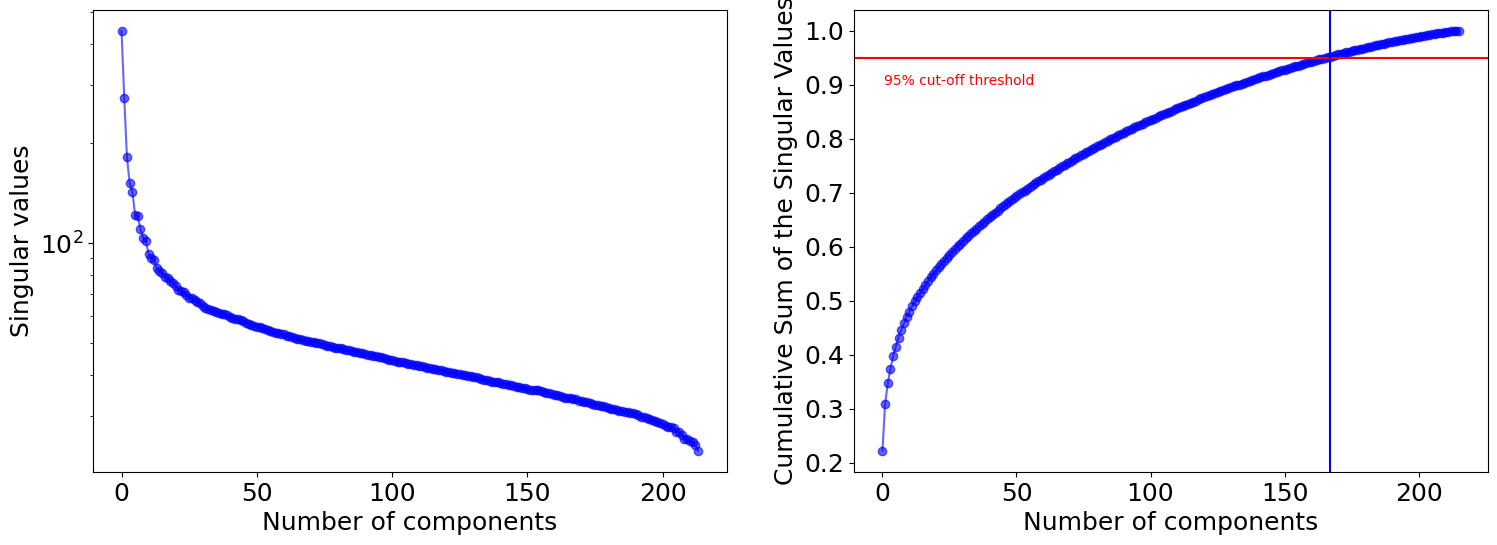

In [43]:
fig1= plt.figure(figsize= (18,6))
ax1 = fig1.add_subplot(121)
ax1.semilogy(pca_mysvd.S[:-2], '-o', color= 'b', alpha= 0.6)
ax1.set_xlabel('Number of components')
ax1.set_ylabel('Singular values')
ax2 = fig1.add_subplot(122)
ax2.plot(pca_mysvd.cum_sum_singular.round(4), '-o', color= 'b', alpha= 0.6)

ax2.set_xlabel('Number of components')
ax2.set_ylabel('Cumulative Sum of the Singular Values')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.axvline(x=pca_mysvd.n_components, color='b', linestyle='-')
plt.text(0.5, 0.9, '95% cut-off threshold', color = 'red', fontsize=10)

plt.show()

<ipython-input-5-9ccdcc416f75>:87: ComplexWarning: Casting complex values to real discards the imaginary part
  self.RMSE = sqrt(MSE)/ sqrt(X_std.shape[1])


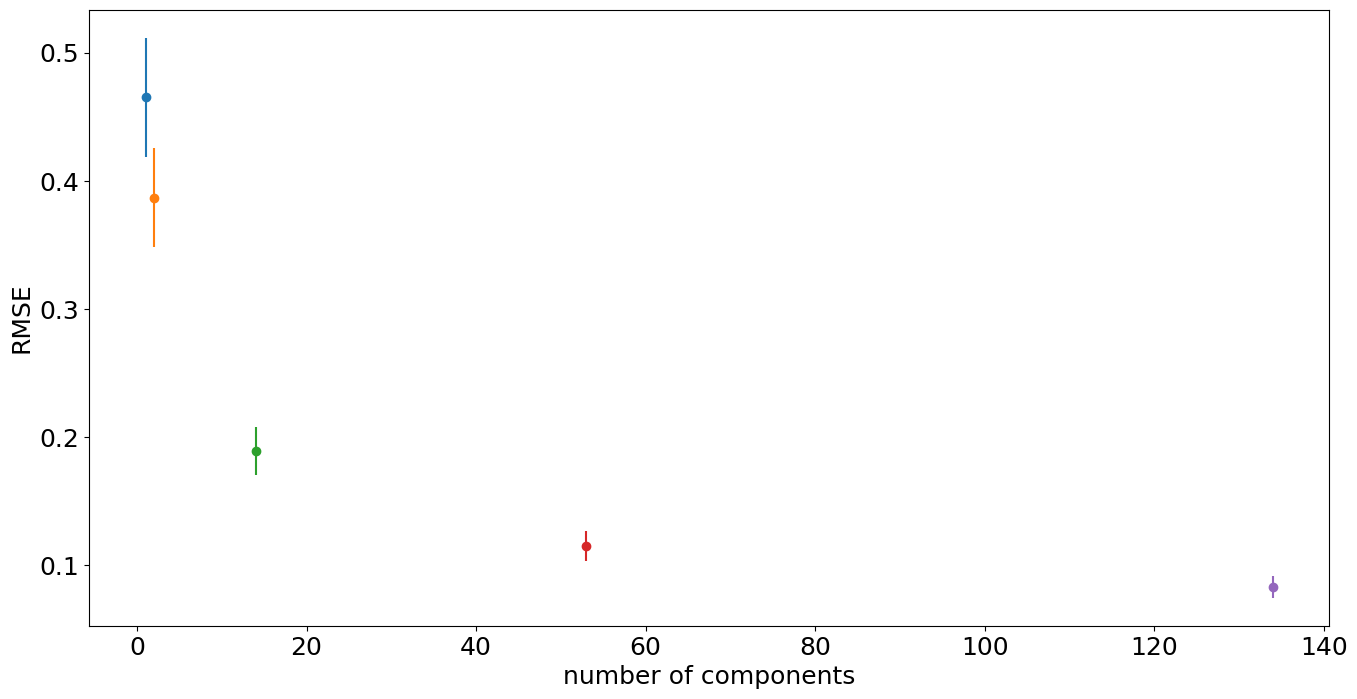

In [6]:
for i in range(10,100, 20):
  pca_mysvd = Mysvd(i/100)
  pca_mysvd_fit = pca_mysvd.fit(obs)
  X_mysvd_projected= pca_mysvd.transform(obs)
  k= pca_mysvd.n_components

  # also vary with the x-position
  lower_error = 0.1 * pca_mysvd.RMSE
  upper_error = pca_mysvd.RMSE
  asymmetric_error = [lower_error, upper_error]
  plt.errorbar(k, upper_error , lower_error, fmt= 'o')
  plt.xlabel("number of components")
  plt.ylabel("RMSE")


# **References:**

[Principal Component Analysis (PCA) from Scratch](https://bagheri365.github.io/blog/Principal-Component-Analysis-from-Scratch/)
